<a href="https://colab.research.google.com/github/blankon123/random-analytics/blob/main/Messy_VS_Tidy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cek versi Tensorflow
import tensorflow as tf

print(tf.__version__)

2.6.0


In [2]:
#Download dataset dari kaggle
from google.colab import files

files.upload()

! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d cdawn1/messy-vs-clean-room

Saving kaggle.json to kaggle.json
 98% 66.0M/67.1M [00:00<00:00, 118MB/s]
100% 67.1M/67.1M [00:00<00:00, 124MB/s]


In [9]:
#Ekstraksi zip
from IPython.display import clear_output

!unzip -qq messy-vs-clean-room.zip

clear_output()
!ls images/images

test  train  val


In [ ]:
import cv2 as cv 
from google.colab.patches import cv2_imshow
from skimage import io

#Menampilkan beberapa contoh gambar
lokasis = [k+'/'+os.listdir(image_path+k)[1] for k in kelas]

for lokasi in lokasis:
  image = io.imread(image_path+lokasi) 
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  cv2_imshow(image_2)
  print(image_2.shape, lokasi)

In [14]:
#Pemeriksaan nama kelas
import os
image_path = 'images/images/train'
daftar_kelas = os.listdir(image_path)
daftar_kelas

['clean', 'messy']

In [15]:
#Kelas pilihan
kelas = daftar_kelas

#Jumlah sampel gambar
sample_number = 0

for k in kelas:
  totalFiles = 0
  for base, dirs, files in os.walk(image_path+'/'+k):
      for Files in files:
          totalFiles += 1
  print('Total Files di',k,totalFiles)
  sample_number += totalFiles

print('Total Training ',sample_number)
print('Total Kelas ',len(kelas))

Total Files di clean 96
Total Files di messy 96
Total Training  192
Total Kelas  2


In [21]:
import os

base_dir = '/content/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [24]:
print(os.listdir(train_dir))
print(os.listdir(validation_dir))

['clean', 'messy']
['clean', 'messy']


In [25]:
# menyimpan direktori ruangan rapi pada direktori data training
train_clean_dir = os.path.join(train_dir, 'clean')
 
# menyimpan direktori ruangan berantakan pada direktori data training
train_messy_dir = os.path.join(train_dir, 'messy')
 
# menyimpan direktori ruangan rapi pada direktori data validasi
validation_clean_dir = os.path.join(validation_dir, 'clean')
 
# menyimpan direktori ruangan berantakan pada direktori data validasi
validation_messy_dir = os.path.join(validation_dir, 'messy')

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [51]:
ukuran_target = (150,150)
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=ukuran_target,  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=ukuran_target, # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [87]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [76]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(1, activation='softmax')
])

model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1179712   
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

In [88]:
# compile model dengan 'adam' optimizer loss function 'binary_crossentropy' 
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [89]:
#Karena proses training berjalan lama, diperlukan callback agar ketika goal tercapai (Akurasi>92) , epoch selanjutnya tidak diperlukan
acc = 0.89

class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('val_accuracy')>=acc and logs.get('accuracy')>=acc): 
      print("\ACC >",acc,"!") 
      self.model.stop_training = True 

callbacks = myCallback() 

In [90]:
# latih model dengan model.fit 
history = model.fit(
      train_generator,
      steps_per_epoch=30,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=100, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      callbacks=[callbacks],
      verbose=2)

Epoch 1/100
30/30 - 8s - loss: 0.7305 - accuracy: 0.5167 - val_loss: 0.6915 - val_accuracy: 0.7000
Epoch 2/100
30/30 - 8s - loss: 0.6935 - accuracy: 0.5500 - val_loss: 0.6809 - val_accuracy: 0.8000
Epoch 3/100
30/30 - 8s - loss: 0.6494 - accuracy: 0.5917 - val_loss: 0.5391 - val_accuracy: 0.7500
Epoch 4/100
30/30 - 8s - loss: 0.6542 - accuracy: 0.6083 - val_loss: 0.6974 - val_accuracy: 0.5000
Epoch 5/100
30/30 - 7s - loss: 0.6445 - accuracy: 0.6417 - val_loss: 0.4998 - val_accuracy: 0.8500
Epoch 6/100
30/30 - 7s - loss: 0.6550 - accuracy: 0.6833 - val_loss: 0.5525 - val_accuracy: 0.7000
Epoch 7/100
30/30 - 8s - loss: 0.6010 - accuracy: 0.7500 - val_loss: 0.5360 - val_accuracy: 0.6500
Epoch 8/100
30/30 - 7s - loss: 0.6171 - accuracy: 0.6750 - val_loss: 0.5626 - val_accuracy: 0.7000
Epoch 9/100
30/30 - 7s - loss: 0.5499 - accuracy: 0.7167 - val_loss: 0.5151 - val_accuracy: 0.7000
Epoch 10/100
30/30 - 7s - loss: 0.5027 - accuracy: 0.7583 - val_loss: 0.4434 - val_accuracy: 0.7500
Epoch 11/

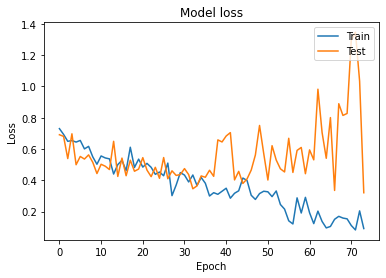

In [91]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train','Test'], loc='upper right') 
plt.show() 

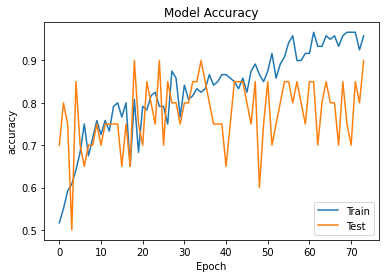

In [92]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.ylabel('accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train','Test'], loc='lower right') 
plt.show() 

Saving Kak Faris.jpeg to Kak Faris.jpeg
Kak Faris.jpeg
clean


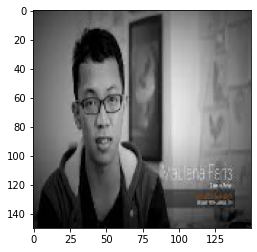

In [99]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('clean')
  else:
    print('messy')

In [102]:
# Konversi model. 
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert() 

#Serialize model ke file 
with tf.io.gfile.GFile('/content/model.tflite', 'wb') as f: 
  f.write(tflite_model) 

INFO:tensorflow:Assets written to: /tmp/tmpckk2r6mx/assets


INFO:tensorflow:Assets written to: /tmp/tmpckk2r6mx/assets
